In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from PIL import Image, ImageDraw
import requests
from io import BytesIO
import os
import pandas as pd

from notebooks_util import * 

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Loading Datasets

In [56]:
np.random.seed(0)
cifar_10_dir = 'data/cifar-10-batches-py'

train_data, train_filenames, train_labels, test_data, test_filenames, test_labels, label_names = \
    load_cifar_10_data(cifar_10_dir)

test_data_ = test_data
np.random.shuffle(test_data_)
test_data_ = np.repeat(test_data_, 7, axis=1)
test_data_ = np.repeat(test_data_, 7, axis=2)

In [57]:
test_data_2 = np.load('data/cifar10.1_v6_data.npy')
np.random.shuffle(test_data_2)
test_data_2_ = test_data_2
test_data_2_ = np.repeat(test_data_2_, 7, axis=1)
test_data_2_ = np.repeat(test_data_2_, 7, axis=2)

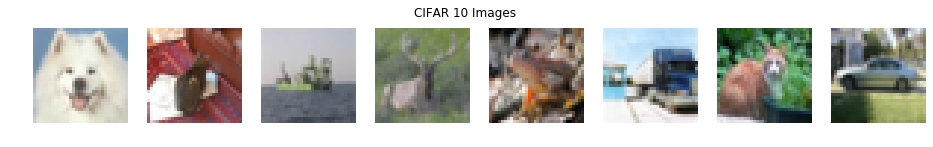

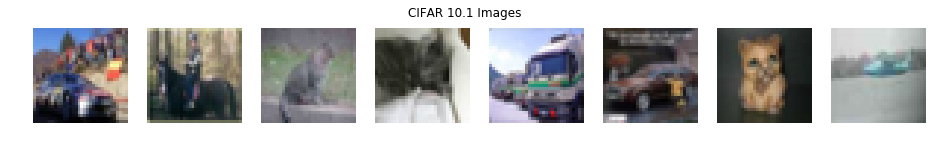

In [58]:
n_show = 8

# Show some examples.
_, ax = plt.subplots(1,n_show, figsize=[16, 2])
plt.suptitle('CIFAR 10 Images')
for i in range(n_show):
    ax[i].imshow(test_data_[i], cmap='gray')
    ax[i].set_axis_off()
    
# Show some examples.
_, ax = plt.subplots(1,n_show, figsize=[16, 2])
plt.suptitle('CIFAR 10.1 Images')
for i in range(n_show):
    ax[i].imshow(test_data_2_[i], cmap='gray')
    ax[i].set_axis_off()

# Get All Mean Activations

In [59]:
# build the VGG16 network with ImageNet weights
vgg = vgg16.VGG16(weights='imagenet', include_top=False)
print('Model loaded.')
vgg.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
________________________________________________________

In [60]:
LAYERS = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
activation_model = get_mean_activations_of_multiple_layers(vgg, LAYERS)

In [ ]:
activations1 = activation_model.predict(test_data_, batch_size=32)

In [ ]:
activations2 = activation_model.predict(test_data_2_, batch_size=32)

In [ ]:
np.save(arr=activations1, file='outputs/cifar10-mean-activations-5-conv-layers')
np.save(arr=activations2, file='outputs/cifar10.1-mean-activations-5-conv-layers')

# Significant Differences within CIFAR10 (?)

In [70]:
def compare_z_scores(arr1, arr2):
    arr_all = np.concatenate((arr1, arr2), axis=0)
    z_diff = (np.mean(arr2, axis=0) - np.mean(arr1, axis=0))/np.std(arr_all, axis=0)
    return z_diff

0.0013022226

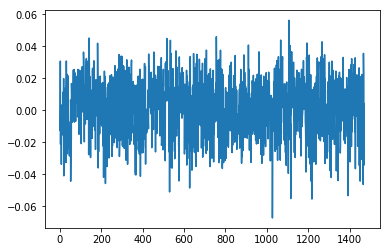

In [71]:
z_diff = compare_z_scores(activations1[:int(activations1.shape[0]/2), :], 
                          activations1[int(activations1.shape[0]/2):, :])
plt.plot(z_diff)
np.nanmean(z_diff)

(array([  3.,  10.,  58., 160., 291., 348., 353., 201.,  44.,   4.]),
 array([-0.06729991, -0.05494095, -0.04258199, -0.03022302, -0.01786406,
        -0.0055051 ,  0.00685386,  0.01921282,  0.03157179,  0.04393075,
         0.05628971], dtype=float32),
 <a list of 10 Patch objects>)

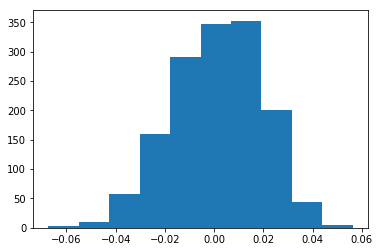

In [72]:
plt.hist(z_diff)

C:\Users\islam\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


-0.031528912

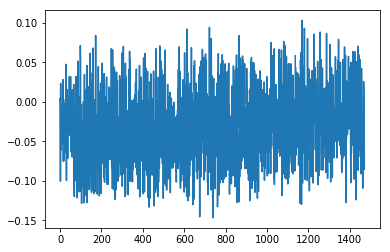

In [73]:
z_diff = compare_z_scores(activations2[:int(activations2.shape[0]/2), :], 
                          activations2[int(activations2.shape[0]/2):, :])
plt.plot(z_diff)
np.nanmean(z_diff)

(array([ 23., 131., 203., 225., 266., 252., 168., 138.,  53.,  12.]),
 array([-0.14684764, -0.12183516, -0.09682268, -0.0718102 , -0.04679772,
        -0.02178524,  0.00322724,  0.02823972,  0.0532522 ,  0.07826468,
         0.10327715], dtype=float32),
 <a list of 10 Patch objects>)

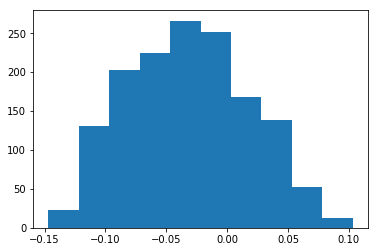

In [74]:
plt.hist(z_diff)

# Between CIFAR10 and CIFAR10.1

0.030680662

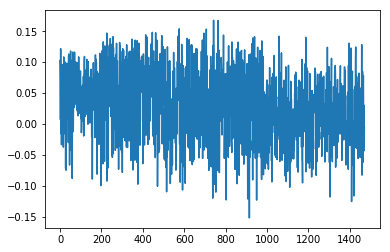

In [75]:
z_diff = compare_z_scores(activations1, activations2)
plt.plot(z_diff)
np.nanmean(z_diff)

(array([  5.,  25.,  84., 177., 222., 286., 261., 240., 150.,  22.]),
 array([-0.15201347, -0.12004124, -0.08806903, -0.05609681, -0.02412459,
         0.00784763,  0.03981985,  0.07179207,  0.10376429,  0.13573651,
         0.16770872], dtype=float32),
 <a list of 10 Patch objects>)

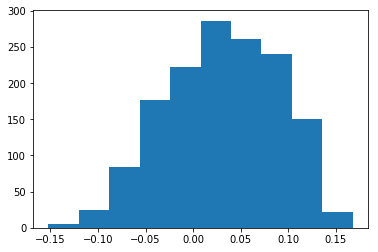

In [76]:
plt.hist(z_diff)

# Statistical test

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from PIL import Image, ImageDraw
import requests
from io import BytesIO
import os
import pandas as pd

from notebooks_util import * 

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
activations1 = np.load('outputs/cifar10-mean-activations-5-conv-layers.npy')
activations2 = np.load('outputs/cifar10.1-mean-activations-5-conv-layers.npy')

In [ ]:
from scipy.stats import ttest_ind
alpha = 0.05
N = 1000

### Within

In [ ]:
stat, p = ttest_ind(activations1[:int(activations1.shape[0]/2), :], 
                    activations1[int(activations1.shape[0]/2):, :], 
                    axis=0, equal_var=False)

plt.semilogy(np.sort(p))
plt.axhline(alpha/len(p), c='k')

In [ ]:
stat, p = ttest_ind(activations2[:int(activations2.shape[0]/2), :], 
                    activations2[int(activations2.shape[0]/2):, :], 
                    axis=0, equal_var=False)

plt.semilogy(np.sort(p))
plt.axhline(alpha/len(p), c='k')

### Between

In [ ]:
stat, p = ttest_ind(activations1, activations2, 
                    axis=0, equal_var=False)

plt.semilogy(np.sort(p))
plt.axhline(alpha/len(p), c='k')

In [ ]:
plt.semilogy(p)

In [ ]:
stat, p = ttest_ind(activations1[:int(activations1.shape[0]/2), :], 
                    activations2[:int(activations2.shape[0]/2), :], 
                    axis=0, equal_var=False)

In [ ]:
plt.semilogy(np.sort(p))
plt.axhline(alpha/len(p), c='k')

# Which filters are most different?

In [ ]:
idx = np.argmin(p)
idx

In [ ]:
ttest_ind(activations1[:, 915], activations2[:, 915], equal_var=False)

In [ ]:
plt.boxplot([activations1[:, 915], activations2[:, 915]])